# Youtube Channel Analysis: Outdoor Boys

***

## Imports & Configurations

In [1]:
import googleapiclient.discovery
from IPython.display import JSON
import os
from dotenv import load_dotenv
from isodate import parse_duration
from dateutil import parser

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor

In [2]:
# color pallete
red, orange, yellow, green, blue, purple = ('#ff6188', '#fc9867', '#ffd866', '#a8dd76', '#78dce8', '#ac9df2')
white, grey, black = ('#fcfcfa', '#2c2a2e', '#211f22')

# global params
matplotlib.rcParams['font.family'] = 'Georgia'
plt.rcParams['figure.facecolor'] = black
plt.rcParams['axes.facecolor'] = black
plt.rcParams['text.color'] = white
plt.rcParams['axes.labelcolor'] = white
plt.rcParams['xtick.color'] = white
plt.rcParams['ytick.color'] = white
matplotlib.rcParams['font.size'] = 12

## Background & Objective/Overview

**Background**: *Outdoor Boys* is a popular YouTube channel featuring a variety of outdoor adventures, including camping, fishing, forging, and family explorations. Run by Luke Nichols and often featuring his sons - Tommy, Nate, and Jacob - the channel has grown to over 10 million subscribers, establishing itself as a major presence in the outdoor and adventure genre on YouTube - a channel I religiously watch.

**Objective**: This notebook aims to analyze Luke Nichols's content strategy and channel performance by collecting data through the YouTube API. 

**Overview**: The goal is to uncover trends in upload frequency, engagement metrics, and overall content strategy. Additionally, this project provides a practical learning experience in data collection and exploratory data analysis.

***

## Data Collection

**Dataset**: The dataset will be obtained using the *Youtube Data API v3*. The API requests are used to retrieve any metadata and engagement data I initially find interesting.

In [3]:
load_dotenv()
api_key = os.environ.get('API_KEY')
channel_ids = ['UCfpCQ89W9wjkHc8J_6eTbBg'] # just Outdoor Boys
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = googleapiclient.discovery.build(api_service_name, api_version, developerKey=api_key)

In [4]:
all_data = []

request = youtube.channels().list(
    part="snippet,contentDetails,statistics",
    id=','.join(channel_ids)
)
response = request.execute()

for item in response['items']:
    data = {'channelName': item['snippet']['title'],
            'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
    }
    all_data.append(data)
        
channel_stats = pd.DataFrame(all_data)

In [5]:
video_ids = []
playlist_id = channel_stats['playlistId'][0]

# first page
request = youtube.playlistItems().list(
    part="snippet,contentDetails",
    playlistId=playlist_id,
    maxResults=50
)
response = request.execute()

video_ids += [item['contentDetails']['videoId'] for item in response['items']]

# rest of pages
next_page_token = response.get('nextPageToken')
while next_page_token is not None:
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50,
        pageToken=next_page_token
        
    )
    response = request.execute()

    video_ids += [item['contentDetails']['videoId'] for item in response['items']]
    next_page_token = response.get('nextPageToken')

In [6]:
all_video_info = []

for i in range(0, len(video_ids), 50):
    
    request = youtube.videos().list(
        part = 'snippet, contentDetails, statistics',
        id= ','.join(video_ids[i:i+50])
    )
    response = request.execute()
    
    for video in response['items']:
        features = {'snippet': ['channelTitle', 'title', 'tags', 'publishedAt'],
                            'statistics': ['viewCount', 'likeCount', 'commentCount', 'favoriteCount'],
                            'contentDetails': ['duration', 'definition', 'caption']}

        video_info = {}
        video_info['video_id'] = video['id']
        
        for key in features.keys():
            for feature in features[key]:
                video_info[feature] = video[key].get(feature, None)
    
        all_video_info.append(video_info)
            
df = pd.DataFrame(all_video_info)

***

## Data Preprocessing

- Dropping columns not needed
- Converting units
- Converting time formats and creating new columns
- Changing data type of columns
- Reordering columns

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483 entries, 0 to 482
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   video_id       483 non-null    object
 1   channelTitle   483 non-null    object
 2   title          483 non-null    object
 3   tags           465 non-null    object
 4   publishedAt    483 non-null    object
 5   viewCount      483 non-null    object
 6   likeCount      483 non-null    object
 7   commentCount   0 non-null      object
 8   favoriteCount  483 non-null    object
 9   duration       483 non-null    object
 10  definition     483 non-null    object
 11  caption        483 non-null    object
dtypes: object(12)
memory usage: 45.4+ KB


In [8]:
df.drop(columns=['commentCount', 'caption', 'favoriteCount', 'channelTitle'], inplace=True)


**Reasons:**
- `commentCount`: Youtube bans comments on channels that feature minors to protect from harm. Therefore all videos have "0" comments.
-  `caption`: No video caption on any of his videos. Therefore, doesnt provide vairety
- `favoriteCount`: found out it is a depricated feature on Youtube, which is why all values are by default 0.
- `channelTitle`: No context is needed for which channel a video came from (as we are making an analysis about one channel)

In [9]:
# youtube ISO 8601 format to total seonds
df['duration'] = df['duration'].apply(lambda x: parse_duration(x).total_seconds())

# convert to datetime to get year, month, and day of the week the video was published
df['publishedAt'] = df['publishedAt'].apply(lambda x: parser.parse(x))
df['year'] = pd.to_numeric(df['publishedAt'].apply(lambda x: x.strftime('%y')))
df['month'] = pd.to_numeric(df['publishedAt'].apply(lambda x: x.strftime('%m')))
df['day_of_week'] = pd.Categorical(df['publishedAt'].apply(lambda x: x.strftime('%A')),
                                   categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                   ordered=True)

# get number of tags per video
df['num_tags'] = df['tags'].apply(lambda x: 0 if x == None else len(x))

# convert data types of columns
df['likeCount'] = pd.to_numeric(df['likeCount'])
df['viewCount'] = pd.to_numeric(df['viewCount'])
df['num_tags'] = pd.to_numeric(df['num_tags'])
df['duration'] = pd.to_numeric(df['duration'])

In [10]:
# rename & reorder attributes
df.columns = ['id', 'title', 'tags', 'published_date', 'num_views', 'num_likes', 'length', 'quality', 'year', 'month', 'day', 'num_tags']
df = df[['id', 'title', 'published_date', 'year', 'month', 'day', 'num_views', 'num_likes', 'length', 'quality', 'tags', 'num_tags']]

In [11]:
# export incase needed for other projects
df.sample(frac=1).reset_index(drop=True).to_csv('./data/videos.csv', index=False)

In [12]:
df.head()

,id,title,published_date,year,month,day,num_views,num_likes,length,quality,tags,num_tags
0,mR3Smq_yBiA,Rebuilding Off-Grid Cabin & Digging Well at Al...,2025-02-08 12:01:05+00:00,25,2,Saturday,5736894,217822,2486.0,hd,"[Homestead, cabin, off-grid, off grid cabin, o...",28
1,C-PW7lDl8g8,Exploring Every Island in Hawaii - 9 weeks fis...,2025-01-11 12:00:14+00:00,25,1,Saturday,6182712,122202,10964.0,hd,"[Fishing, Hawaii, Kauai, Fishing Hawaii, Hawai...",30
2,iys_pmJSp9M,3 Days in Arctic Survival Shelter - Solo Bushc...,2024-12-28 12:01:03+00:00,24,12,Saturday,19914713,509532,1546.0,hd,"[Camping, solo camping, survival camping, bush...",25
3,p0Q0LexfUP0,Searching Jungle for WWII Battlefields (6 Days...,2024-12-14 12:01:04+00:00,24,12,Saturday,6278012,174820,3368.0,hd,"[Palau, Belau, Travel Palau, Palau travel vlog...",22
4,p9yaDeStS7A,"No tent, No sleeping bag - Extreme Winter Surv...",2024-11-30 12:00:56+00:00,24,11,Saturday,19354990,551746,1380.0,hd,"[camping, survival, winter survival, survival ...",22


***

## Exploratory Data Analysis

For reference, here is a table of variable definitions:

| Variable    | Description |
| ----------- | ----------- |
| id       |  video id   |
| published_date   |  the date when video was published (year-month-day hour:minute:second+timezone)       |
| year   |    the year the video was published    |
| month   |   the month the video was published    |
| day   |   the day of the week the video was published      |
| num_views   |  the total number of views per video      |
| num_likes   |  the total number of likes per video      |
| length   |  the duration of video (in seonds)       |
| quality   |  video quality: either standard or high definition (sd, hd)    |
| tags   |  labels used for describing video content      |
| num_tags   |   the number of tags      |

### 

### Behavioral Analysis: Looking into the Content Strategies of Luke Nichols

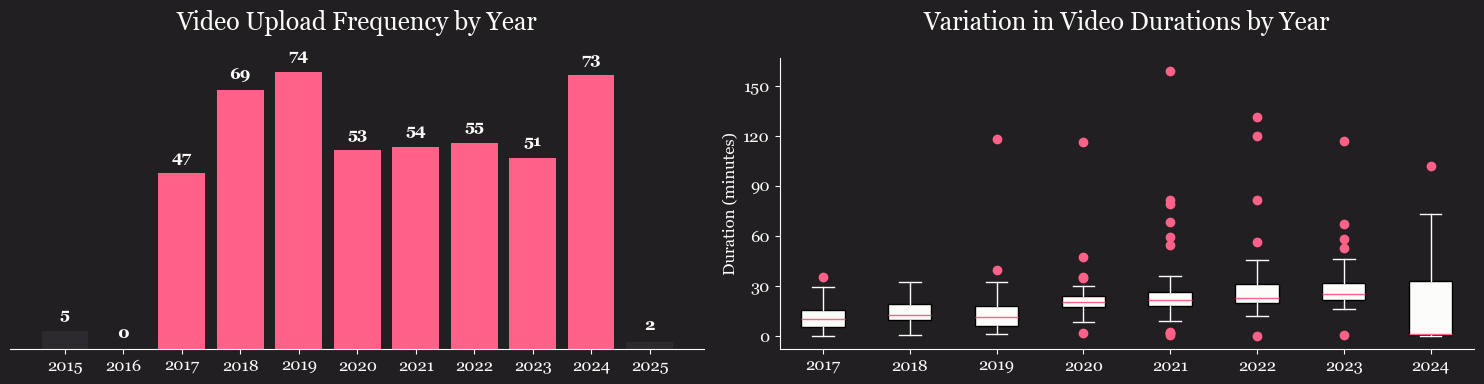

[longest video uploaded]
- title: Exploring Every Island in Hawaii - 9 weeks fishing, camping, hiking, diving & exploring 
- duration: 3.05hrs
[2024 duration] 
- median: 59.0s


count    483.000000
mean      19.974672
std       20.127264
min        0.000000
25%        8.250000
50%       18.050000
75%       24.958333
max      182.733333
Name: length, dtype: float64

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))

# bar plot
years = np.arange(15, 26)
year_value = df['year'].value_counts()
adj_year_value = year_value.reindex(year_value.index.append(pd.Index([16])), fill_value=0).sort_index() # since 2016 is missing
colors1 = [grey if (year == 15) or (year == 25) else red for year in adj_year_value.index]

bar = ax1.bar(years, adj_year_value, color=colors1)

ax1.bar_label(bar, color=white, padding=6, label_type='edge', fontweight='bold') # i need the bar object
ax1.set_title('Video Upload Frequency by Year', fontsize=18, pad=20)
ax1.yaxis.set_visible(False)
ax1.set_xticks(years)
ax1.set_xticklabels(adj_year_value.index + 2000)
ax1.spines[['bottom']].set_color(white)
ax1.spines[['top', 'right', 'left']].set_visible(False)

# boxplot
updated_years = np.arange(17, 25)
duration_yearly = [df.loc[df['year'] == x,'length']/60 for x in updated_years]
colors2 = 8 * [white]

bplot = ax2.boxplot(duration_yearly, patch_artist=True, flierprops=dict(markerfacecolor=red, markeredgecolor=red))

for patch, color in zip(bplot['boxes'], colors2):
    patch.set_facecolor(color)

for item in ['whiskers', 'fliers', 'caps', 'medians']:
    for box, c in zip(bplot[item], (14 * [white]) + (2 * [white])):
        if item == 'medians':
            box.set(color=red)
        else:
            box.set(color=c)

ax2.set_title('Variation in Video Durations by Year', fontsize=18, pad=20)
ax2.set_ylabel('Duration (minutes)')
ax2.set_yticks(np.arange(0, 180, 30))
ax2.set_xticklabels(2000 + updated_years)
ax2.spines[['top', 'right']].set_visible(False)
ax2.spines[['bottom', 'left']].set_color(white)

plt.tight_layout()
plt.show()

duration_outlier = df[['id', 'title', 'length']].sort_values(by='length', ascending=False).iloc[0]
print(f'[longest video uploaded]\n- title: {duration_outlier['title']} \n- duration: {round(duration_outlier['length']/60/60, 2)}hrs')
print(f'[2024 duration] \n- median: {df.loc[df['year'] == 24, 'length'].median()}s')

(df['length']/60).describe()

**Analysis: Video Upload Frequency by Year**
- His most uploads by year is in 2019 with 74 videos followed by 2024 with 73 videos.
- Luke started uploading videos on his channel "Outdoor Boys" since 2015. Only 5 videos were uploaded the first year and none in 2016. This could indicate that 2015 was a year of casual/personal uploads and did not pursue the growth of his Youtube channel until 2017. I have collected this data early this year (currently Feburary), which is the reason why there are only a few uploads in 2025. For majority of our analysis moving forward, I will be omitting the year 2015, 2016, and 2025.

**Analysis: Variations in Video Durations by Year**
- There seems to be a gradual increase in the average duration of his videos.
- Overall, most of his videos fall between 8 to 25 minutes, with 50% of the videos having views with this range.
- His longest video is about 3 hours.
- [His career in 2024] 
    - This year displays a sharp decline in average duration with 50% of his videos well below 5 minutes.
    - Even with 1 outlier, the boxplot displays the widest whiskers compared to all other years and indicating a broader variation (more spread) in Youtube video length.
  

#### Weekly Upload Habits Across Luke's Career

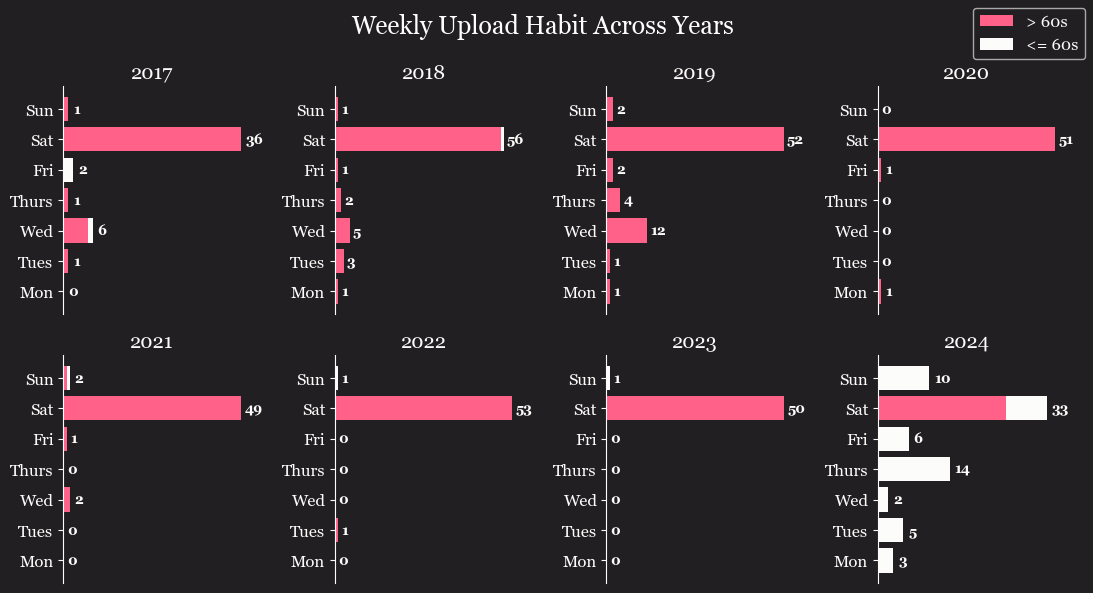

[2024 short form content] count: 48
[2024 long form content] count: 25


In [14]:
# barplots
fig, axes = plt.subplots(2,4, figsize=(11,6))
fig.suptitle('Weekly Upload Habit Across Years', fontsize=18, color='white')

years = np.arange(17,25)
u_years = years + 2000

i = 0
for row in axes:
    for ax in row:
        vid_vals = df.loc[(df['year'] == years[i]) & (df['length'] > 60),'day'].value_counts().sort_index()
        short_vals = df.loc[(df['year'] == years[i]) & (df['length'] <= 60),'day'].value_counts().sort_index()
        total_height = vid_vals + short_vals

        vid_bar = ax.barh(vid_vals.index, vid_vals, color=red, label = '> 60s')
        short_bar = ax.barh(short_vals.index, short_vals, left=vid_vals, color=white, label='<= 60s')
        
        for y, total in zip(vid_vals.index, total_height):
            ax.text(total + 1, y, str(total), va='center', fontsize=10, fontweight='bold', color=white)
        
        ax.set_title(u_years[i])
        ax.set_yticks(vid_vals.index)
        ax.set_yticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
        ax.xaxis.set_visible(False)
        ax.spines[['left']].set_color(white)
        ax.spines[['top', 'right', 'bottom']].set_visible(False)
        i+=1
        
        
fig.legend(handles=[vid_bar, short_bar], loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()

print(f'[2024 short form content] count: {df.loc[(df['year'] == 24) & (df['length'] <= 60) , 'day'].value_counts().sum()}')
print(f'[2024 long form content] count: {df.loc[(df['year'] == 24) & (df['length'] > 60) , 'day'].value_counts().sum()}')

**Analysis: Weekly Upload Habit Across Years**
- Luke’s upload schedule has remained fairly consistent, with most videos being uploaded on Saturdays and very few on other days.
- In 2024, 65.8% of Luke’s videos were under 1 minute, likely indicating a shift toward short-form content or "YouTube Shorts".
    - This explains the increased variation in video duration observed earlier, as well as the drop in average video length.
    - Since YouTube Shorts was introduced in 2020, his videos 60 seconds or below before then were just standard YouTube uploads rather than Shorts.
    - His content strategy appears to have shifted, focusing more on Shorts - likely wanting to explore how this new format impacts his reach and engagement.

### Comparative Analysis: Relationship Between Likes and Views (Random Sample Concensus)

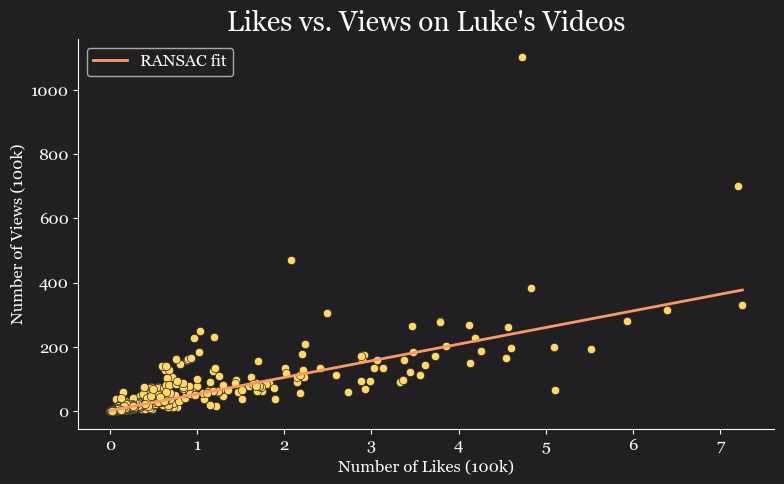

RANSAC fit slope: 51.812763542203996


In [15]:
np.random.seed(13)
ransac = RANSACRegressor(max_trials=100_000)
x = df['num_likes'].values.reshape(-1, 1)
y = df['num_views'].values
ransac.fit(x, y)
x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)  
y_pred = ransac.predict(x_range)

fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(df['num_likes']/100_000, df['num_views']/100_000, color=yellow, edgecolors=grey, linewidths=0.5)
ax.plot(x_range/100_000, y_pred/100_000, color=orange, linewidth=2, label='RANSAC fit')

ax.set_title('Likes vs. Views on Luke\'s Videos', fontsize=20)
ax.set_xlabel('Number of Likes (100k)')
ax.set_ylabel('Number of Views (100k)')

ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_color(white)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

print(f'RANSAC fit slope: {ransac.estimator_.coef_[0]}')

**Analysis: Views v.s. Likes**
- As expected, there is a positive relationship between views and likes - more views generally lead to more likes, as a larger audience increases the likelihood of engagement.
- To better quantify this relationship while minimizing the impact of outliers, the RANSAC model was used. According to the model, approximately one in every 52 viewers liked a video on Luke's channel. This is comparatively outstanding to some of the other viral channels I personally see on Youtube.

### Time series analysis: Measuring Performance of Videos 
People often use views to gauge a video's success. However, a view only indicates that someone clicked on the video - it measures reach, not engagement. It doesn’t guarantee that they watched the video fully or enjoyed it, as views can be inflated by accidental clicks or misleading (clickbait) titles and thumbnails. On the other hand, a like represents active engagement, often signaling approval and satisfaction with the content. For this reason, I am using `num_likes` as a metric to analyze how his audience has grown over his career.

In [16]:
df['outlier'] = False
for x in np.arange(17, 25):
    col = df.loc[df['year'] == x, 'num_likes']
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    df.loc[df['year'] == x, 'outlier'] = col > upper
print(f'# of outliers: {df['outlier'].sum()}')

# of outliers: 38


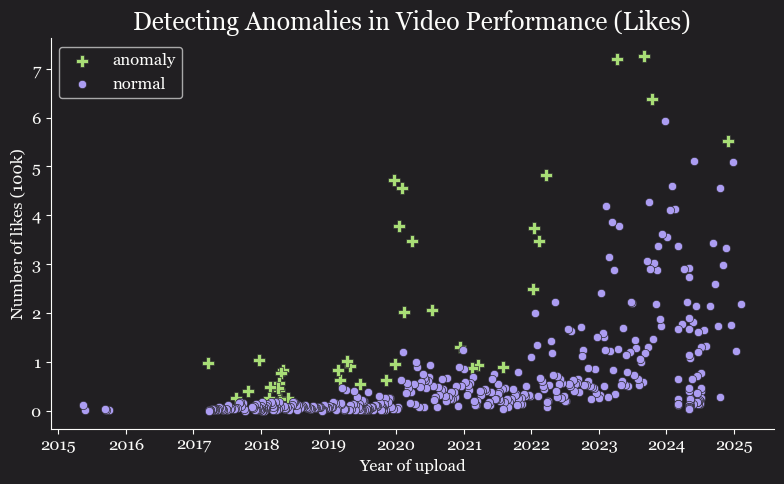

In [17]:
fig, ax = plt.subplots(figsize=(8,5))

ax.scatter(df.loc[df['outlier'] == True,'published_date'], df.loc[df['outlier'] == True, 'num_likes']/100_000, 
           color=green, label='anomaly',
           marker='P',
           s=70,
           edgecolors=grey,
           linewidths=0.5)
ax.scatter(df.loc[df['outlier'] == False,'published_date'], df.loc[df['outlier'] == False, 'num_likes']/100_000,
           color=purple,
           label='normal',
           edgecolors=grey,
           linewidths=0.5)

ax.set_title('Detecting Anomalies in Video Performance (Likes)', fontsize=18)
plt.legend(loc='upper left')
ax.set_ylabel('Number of likes (100k)')
ax.set_xlabel('Year of upload')

ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_color(white)

plt.tight_layout()
plt.show()

**Analysis: Detecting Anomalies in Video Performance (Likes)**
- The anomalies represent videos that performed significantly better (outliers based on likes) compared to other videos in the same year.
- Soley looking at likes, his audience has been growing exponentially with serveral anomalies each year, likely attracting new viewers who continue engaging with his content. This surge in engagement aligns with YouTube's recommendation system, which prioritizes videos with high likes, comments, and shares, further growing his reach to a broader audience.

***

## Brief EDA Summary


- This notebook provides an analysis of Luke Nichols's YouTube channel, Outdoor Boys, focusing on content strategy, upload frequency, video duration, and audience engagement. By leveraging the YouTube API, trends in video uploads and viewer interaction were uncovered. 
- Notably, Luke's upload frequency peaked in 2019, with a subsequent rise in 2024.
- Over time, video durations have increased, with a notable drop in average duration in 2024 due to a shift towards YouTube Shorts.
- Overall, the analysis highlights Luke Nichols's evolving content strategy, with longer-form content dominating in previous years and a noticeable shift toward YouTube Shorts in 2024. The strong engagement trends suggest that strategic scheduling (particularly Saturday uploads) and experimenting with different content formats have contributed to his channel's sustained growth. While this analysis uncovers meaningful insights, further investigation - such as analysis of returning viewers vs. new viewers or taking a deep look into anomalous videos and why they had usually high engagement - could provide deeper insights into what drives audience engagement on youtube overall.

***